<a href="https://colab.research.google.com/github/maryamzamani11/ANN_Temperature_Timeseries/blob/main/TF_ANN_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
from google.colab import files
import io 
data = files.upload()

Saving Temperature.csv to Temperature.csv


In [ ]:
df = pd.read_csv(io.BytesIO(data['Temperature.csv']))

In [ ]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,North America,US,New York,New York City,1,1,1995,44.0
1,North America,US,New York,New York City,1,2,1995,41.8
2,North America,US,New York,New York City,1,3,1995,28.1
3,North America,US,New York,New York City,1,4,1995,31.7
4,North America,US,New York,New York City,1,5,1995,21.3


I remove days of Feb 29, this leads all years to have 365 days. You will see later in this code that helps for making the data stationary easier.

In [ ]:
# Get indexes where Month is 2 and Day is 29
indexNames = df[(df['Month'] == 2) & (df['Day'] == 29)].index
# Delete these row indexes from data
df.drop(indexNames , inplace=True)

I convert the separate columns of Month, Day and Year into one date-time colum and set that as the index column.  

In [ ]:
df['Date']=pd.to_datetime(df[['Year', 'Month', 'Day']])
df.drop(['Year','Month','Day'],axis=1,inplace=True)
df=df.set_index('Date')
df.head(2)

,Region,Country,State,City,AvgTemperature
Date,,,,,
1995-01-01,North America,US,New York,New York City,44.0
1995-01-02,North America,US,New York,New York City,41.8


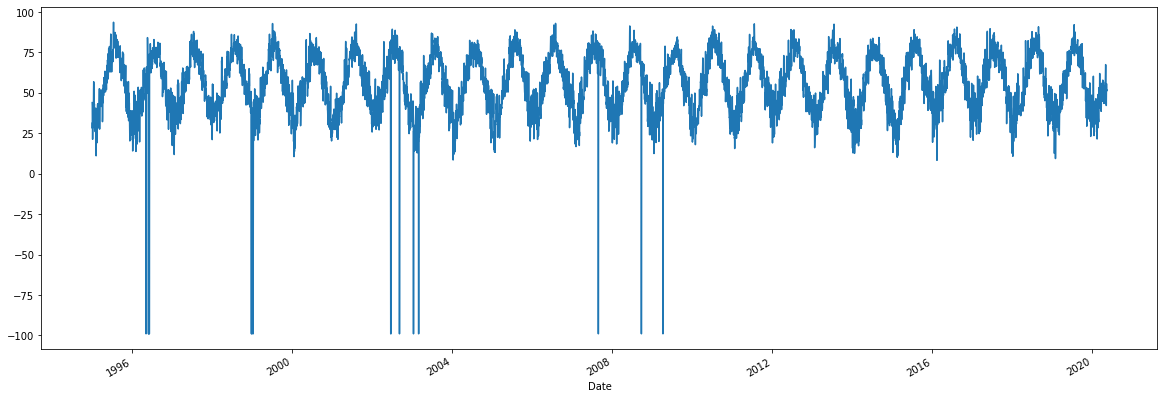

In [ ]:
plt.figure(figsize=(20,7))
df['AvgTemperature'].plot()

There are some outliers in the data-set, those couldn't be a true temperature data, having a sudden drop to -99 in the peaks is not normal! I can deal with these points in two ways, either remove them or fill them with the previouse value. I choose the latter one.

In [ ]:
df=df.assign(AvgTemperature=df.AvgTemperature.mask(df.AvgTemperature.lt(-50)).ffill())

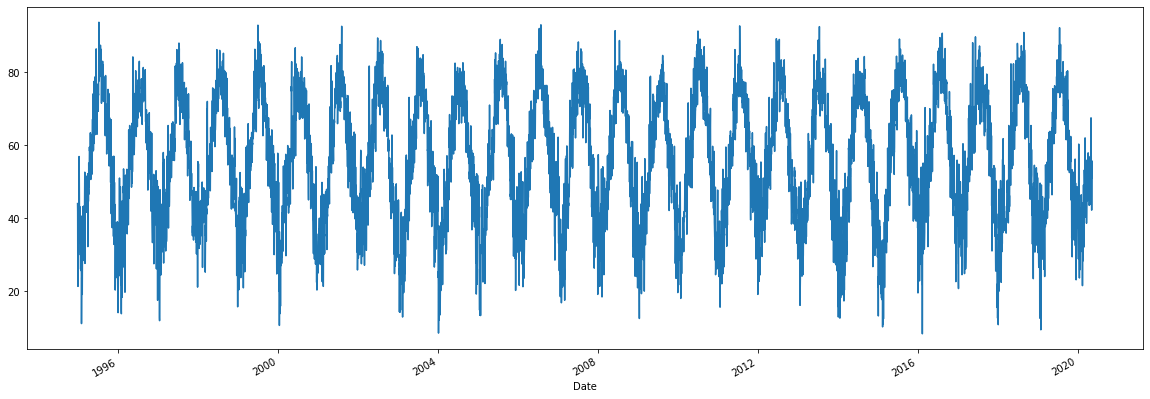

In [ ]:
plt.figure(figsize=(20,7))
df['AvgTemperature'].plot()

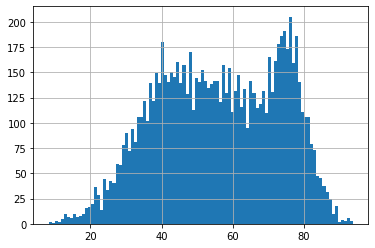

In [ ]:
df['AvgTemperature'].hist(bins=100)

We can decompose the time series into trend + seasonality + noise. 
That could be done using additivie model which assumes that the time series is the sum of these components or it can be multiplicative which assumes that the time series is the multiplication of these components. 



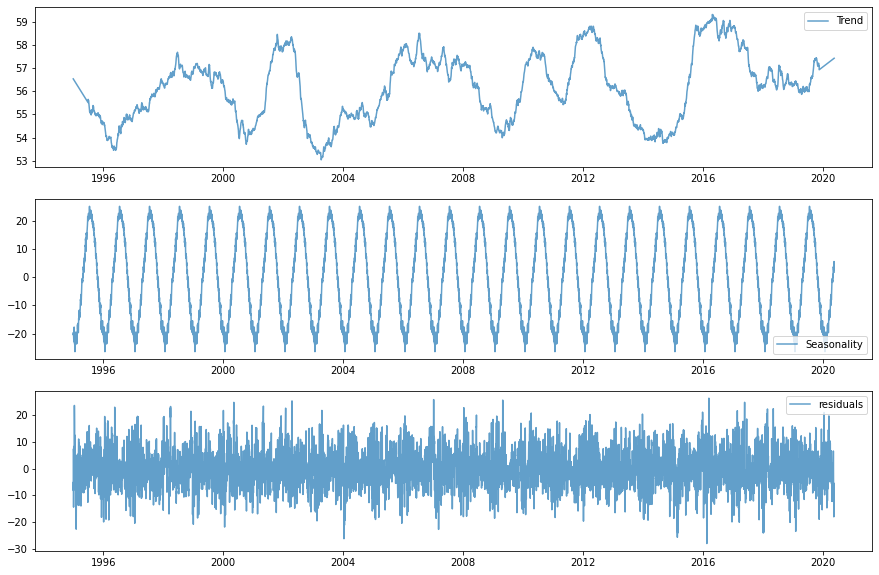

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

sd_AVT = sd(df['AvgTemperature'], period=365, extrapolate_trend='freq')

plt.figure(figsize=(15,10))
ax1=plt.subplot(311)
ax1.plot(sd_AVT.trend, label='Trend',alpha=0.7)
plt.legend()

ax2=plt.subplot(312)
ax2.plot(sd_AVT.seasonal, label='Seasonality',alpha=0.7)
plt.legend()

ax3=plt.subplot(313)
ax3.plot(sd_AVT.resid, label='residuals',alpha=0.7)
plt.legend()



If the second and third time series in above plots are removed from the initial time series, the first time series will be reached, I examine this here. 

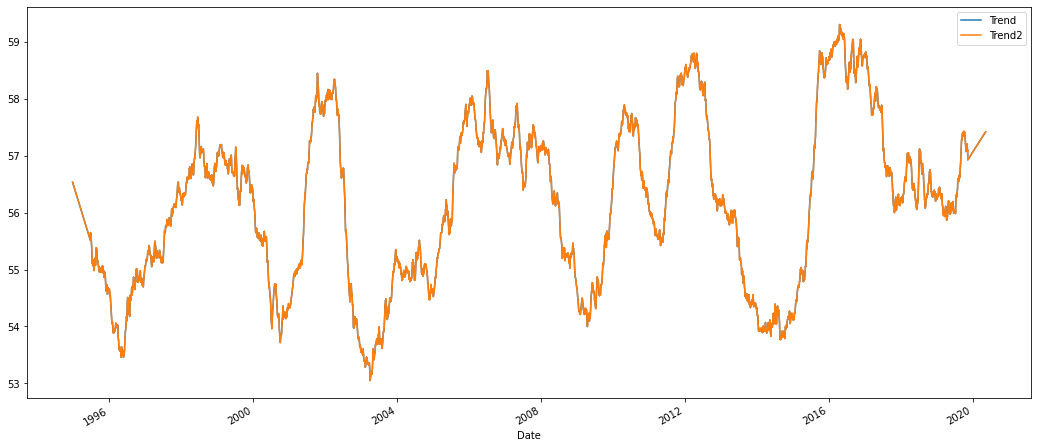

In [ ]:
df['Trend']=sd_AVT.trend.to_numpy()
df['Noise'] = sd_AVT.resid.to_numpy()
df['Seasonality'] = sd_AVT.seasonal.to_numpy()

df['Trend2'] = df['AvgTemperature'] - df['Seasonality'] - df['Noise']
df[['Trend','Trend2']].plot(figsize=(18,8))

Begining and the end of the above time series are just linear lines, showing just the trend. 

For building any time series models, we need to make the time series stationary. I remove seasonality by subtracting the temperature value from the values of the same day in the last year.

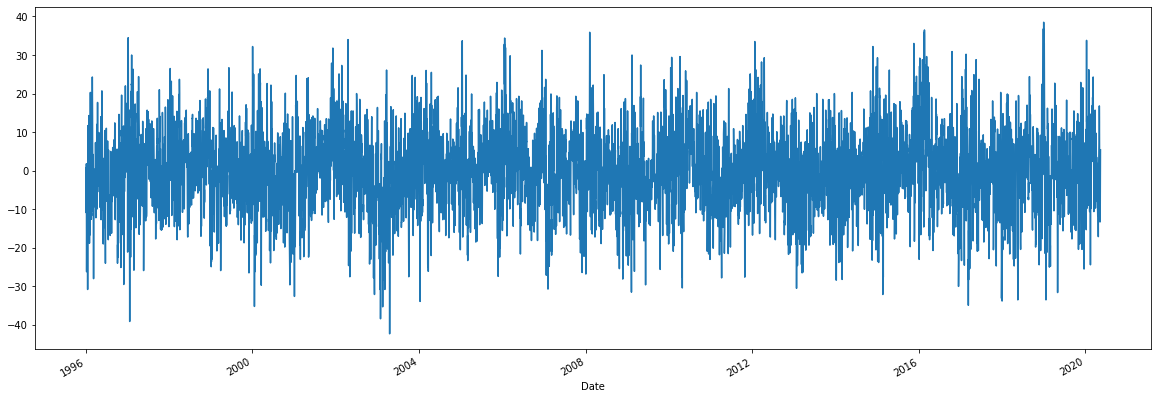

In [ ]:
df['Diff365'] = df['AvgTemperature'].diff(365) 
df['Diff365'].plot(figsize=(20,7))

I check for stationarity. 

In [ ]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(df['Diff365'].iloc[365:])

(-16.02414999144607,
 6.157842890426803e-29,
 19,
 8873,
 {'1%': -3.4310872019402154,
  '5%': -2.8618657948480255,
  '10%': -2.566943415595445},
 59918.800565460646)

The first line of above output is the Augmented Dicken-Fuller score, the more negative this score is, it means we can reject the null hypothesis and the time series is stationary, the second line refers to the p-value. Since the AD-Fuller score is less than its values in 1% significant level and the p_value is near zero, we can reject the null hypothesis (the data is stationary).

## ANN

For the first step, I need to make a supervised dataset from this time series. For that, I choose T=7 data points as features dimension and the next value after the 7 points as target. That means we use the temperature of the last 7 days to predict tomorrow's temperature.

In [ ]:
Temperature = df['Diff365'].dropna().to_numpy()
T = 7
X = []
Y = []


for t in range(len(Temperature)-T):
    x = Temperature[t:t+T]
    X.append(x)
    y = Temperature[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)    # this is the number of samples in the supervised dataset   



I choose Ntest = 10

In [ ]:
# split train and test sets
Ntest = 10
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [ ]:
# build the model
model = tf.keras.models.Sequential()
model.add(Input(shape=(T,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = 'mae'
)

In [ ]:
M_Fitting = model.fit(
    Xtrain,
    Ytrain,
    epochs = 100,
    validation_data = (Xtest, Ytest),
    verbose=0
)

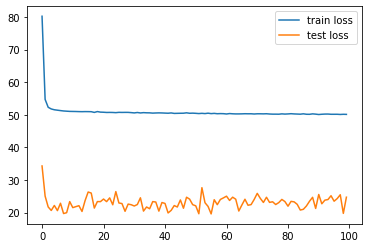

In [ ]:
plt.plot(M_Fitting.history['loss'], label = 'train loss')
plt.plot(M_Fitting.history['val_loss'], label='test loss')
plt.legend()

In [ ]:
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
# save the index of train and test set as booleans for later use
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
train_idx[:T+365] = False # First 365 values are Nan and the first T values are not predictable 

In [ ]:
Xtest

array([[ -9.9,   0.9,   1.3,   4.1,   6. ,   7.2,  16.8],
       [  0.9,   1.3,   4.1,   6. ,   7.2,  16.8,  12.5],
       [  1.3,   4.1,   6. ,   7.2,  16.8,  12.5,   1.1],
       [  4.1,   6. ,   7.2,  16.8,  12.5,   1.1,  -3.4],
       [  6. ,   7.2,  16.8,  12.5,   1.1,  -3.4,   0.4],
       [  7.2,  16.8,  12.5,   1.1,  -3.4,   0.4,  -6.5],
       [ 16.8,  12.5,   1.1,  -3.4,   0.4,  -6.5, -13.3],
       [ 12.5,   1.1,  -3.4,   0.4,  -6.5, -13.3, -11.6],
       [  1.1,  -3.4,   0.4,  -6.5, -13.3, -11.6,  -9. ],
       [ -3.4,   0.4,  -6.5, -13.3, -11.6,  -9. ,  -1.5]])

I use 7 data points to predict the next value. To apply the model for the test set, I can use the first row of test set and predict the next value, again use the next 7 points including the predicted value for predicting the second value and continue in this way. This is called multi-step forecasting.

In [ ]:

predictions = []
features_x = Xtest[0]

while len(predictions) < Ntest:
    p = model.predict(features_x.reshape(1,-1))[0]
    predictions.append(p)
    # remove the first value in features_x and add the predicted value to the end of the list
    features_x = np.roll(features_x, -1)
    features_x[-1] = p
    

In [ ]:
# Store the predicted values in the dataframe
df.loc[test_idx, 'ANN_Multistep_pred'] = predictions

In [ ]:
df

,Region,Country,State,City,AvgTemperature,Diff365,ANN_Multistep_pred
Date,,,,,,,
1995-01-01,North America,US,New York,New York City,44.0,NaN,NaN
1995-01-02,North America,US,New York,New York City,41.8,NaN,NaN
1995-01-03,North America,US,New York,New York City,28.1,NaN,NaN
1995-01-04,North America,US,New York,New York City,31.7,NaN,NaN
1995-01-05,North America,US,New York,New York City,21.3,NaN,NaN
...,...,...,...,...,...,...,...
2020-05-09,North America,US,New York,New York City,42.2,-13.3,2.550752
2020-05-10,North America,US,New York,New York City,50.3,-11.6,1.770482
2020-05-11,North America,US,New York,New York City,55.7,-9.0,0.868423


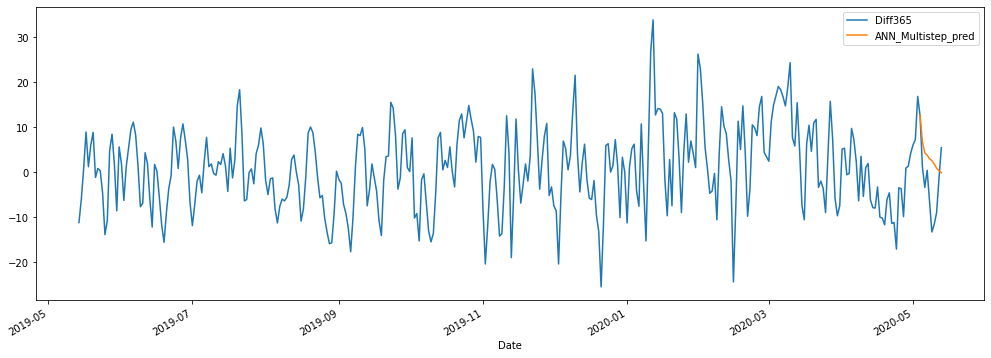

In [ ]:
df[['Diff365','ANN_Multistep_pred']].iloc[-365:].plot(figsize=(17,6))

To see the true temperature I add up the values that I subtracted. 

In [ ]:
df['ShiftTemperature'] = df['AvgTemperature'].shift(365)


In [ ]:
df.loc[test_idx, 'One_target_test'] = df['ANN_Multistep_pred'] + df['ShiftTemperature']

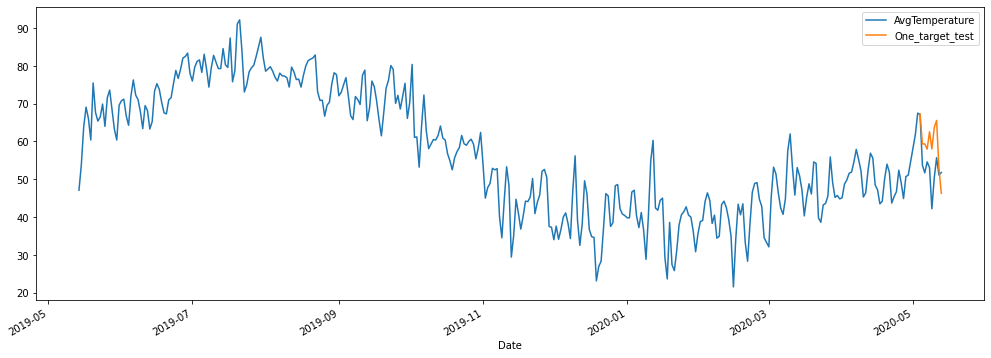

In [ ]:
df[['AvgTemperature','One_target_test']].iloc[-365:].plot(figsize=(17,6))

Now I make another set of supervised data. This time, instead of predicting only just one day ahead, I use several days for as the target set.

In [ ]:

Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(Temperature)-Tx-Ty+1):
    x = Temperature[t:t+Tx]
    X.append(x)
    y = Temperature[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1,Tx)
Y = np.array(Y).reshape(-1,Ty)
N = len(X)



In [ ]:
Xtrain, Ytrain = X[:-1], Y[:-1]
Xtest, Ytest = X[-1:], Y[-1:]

In [ ]:
# Basic ANN
#i = Input(shape=(Tx,))
#x = Dense(32, activation= 'relu')(i)
#x = Dense(Ty)(x)
#model = Model(i,x)

# build the model
model = tf.keras.models.Sequential()
model.add(Input(shape=(Tx,)))
model.add(Dense(32,activation='relu'))
model.add(Dense(Ty))

In [ ]:
model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [ ]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest, Ytest),
    verbose=0
)

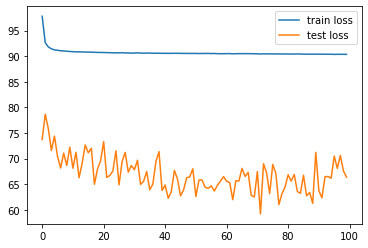

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [ ]:
train_pred = model.predict(Xtrain)
test_pred = model.predict(Xtest)
print(train_pred.shape)
print(test_pred.shape)

(8876, 10)
(1, 10)


In [ ]:
test_pred

array([[12.353684  ,  6.1116457 ,  3.3292987 ,  2.3285253 ,  1.8633369 ,
         1.8917096 ,  1.2593174 ,  0.83243006,  0.2923313 ,  0.56178105]],
      dtype=float32)

In [ ]:
train_pred = train_pred[:,0] 
test_pred = test_pred[0]

In [ ]:
df.loc[test_idx, 'predTest_10Targets'] = test_pred

In [ ]:
df.loc[test_idx, 'Multi_targets_test'] = df['predTest_10Targets'] + df['ShiftTemperature']

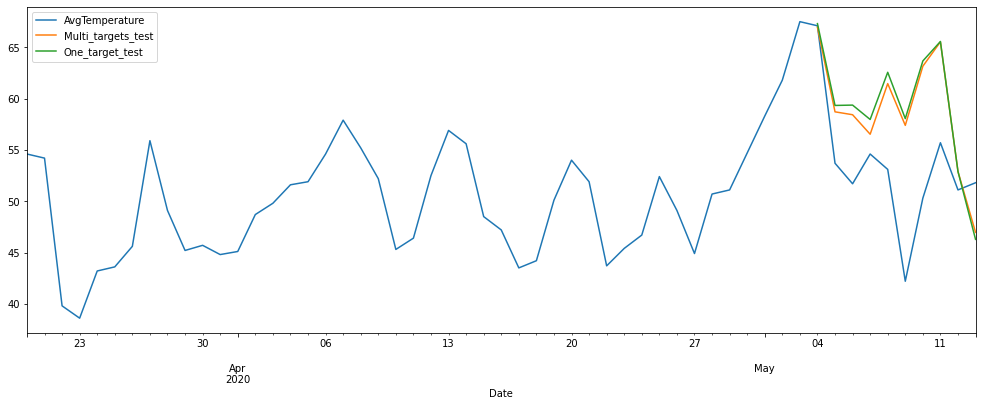

In [ ]:
df[['AvgTemperature','Multi_targets_test','One_target_test']].iloc[-55:].plot(figsize=(17,6))